In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import optuna
from optuna.trial import TrialState

import os
import pickle as pkl
import random 
random.seed(19)

import optuna
from optuna.trial import TrialState

from tqdm import tqdm
from PIL import Image

#you need the cutmix package from https://github.com/ildoonet/cutmix

from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss

import gc

f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BSZ = 32
IMG_SIZE = 224

In [3]:
train_data_path = "./data/training"
test_data_path = "./data/testing"

# Important 
Remove the corrupted images from the dataset before you run this code:

table_2366/3385
glass_1934

The folders structure for the network is 
data/training
data/testing

These folder contain the images directly

In [4]:
class GlassesAndTables(Dataset):
    def __init__(self, root_dir="./data/", custom_transforms=None, mode="training", use_cache=True, subset=True, subset_size=1000):
        self.root_dir = root_dir
        self.mode = mode
        self.data_path = os.path.join(self.root_dir, self.mode)
        self.data = []
        self.labels = []
        self.img_names = []
        self.labels_dict = {"glass": 0, "table": 1}
        for sub, dir, files in os.walk(self.data_path):
            for file in files:
                self.data.append(os.path.join(sub, file))
                self.img_names.append(file)
                self.labels.append(self.labels_dict.get(file.split("_")[0]))
        self.labels = torch.tensor(self.labels)
        if mode == "training":
            self.transforms = custom_transforms['train']
        else:
            self.transforms = custom_transforms['test']
        
        self.USE_CACHE = use_cache
        self.cache_path = os.path.join('data/cache', self.mode)
        if not os.path.exists(self.cache_path):
            os.makedirs(self.cache_path)
        
        if subset and self.mode == "training":
            random_list_glass = sorted(random.sample(range(3198),1000))
            random_list_table = sorted(random.sample(range(3199, 6397), 1000))
            random_list = random_list_table + random_list_glass
            self.data = [self.data[idx] for idx in random_list]
            self.labels = [self.labels[idx] for idx in random_list]
            self.img_names = [self.img_names[idx] for idx in random_list]
            #print(np.sum(self.labels))       # This line output 1000 which proved the randomness work

    def __getitem__(self, idx):
        cache_file = os.path.join(self.cache_path, self.img_names[idx][:-3] + 'pkl')
        
        if self.USE_CACHE and os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                img = pkl.load(f)
        else:
            try:
                img = Image.open(self.data[idx]).convert('RGB')
                img = img.resize((IMG_SIZE, IMG_SIZE))
            except:
                print(str(self.img_names[idx]) + " is truncated")
            if self.USE_CACHE and not os.path.exists(cache_file):
                with open(cache_file,'wb') as f:
                    pkl.dump(img, f)
                
        img = self.transforms(img)
        label = self.labels[idx]
                
        return img, label
                       

    def __len__(self):
        return len(self.data)

In [5]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()  
    
    loss_list = []
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    model.eval()  
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds==labels)[0])
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch 
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
        
    print(f"Training completed")
    return train_loss, val_loss, valid_acc

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="training", use_cache=True, subset=True)
test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="testing", use_cache=True, subset=True)


#we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 400, 400])  
train_dataset = CutMix(train_dataset, num_class=2, beta=1.0, prob=0.5, num_mix=2)

train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=False)

### 1.1 VGG

In [8]:
model_vgg = models.vgg11(pretrained=True)
model_vgg.classifier[-1] = nn.Linear(4096, 2)
model_vgg = model_vgg.to(device)

optimizer_vgg = torch.optim.SGD(model_vgg.parameters(), lr=0.001)
criterion = CutMixCrossEntropyLoss(True)
scheduler_vgg = torch.optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [9]:
tl_vgg, vl_vgg, va_vgg = train_model(model=model_vgg, optimizer=optimizer_vgg, scheduler=scheduler_vgg, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS
    )

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Epoch 1/10
    Train loss: 0.55568
    Accuracy: 47.25%




100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 6/10
    Train loss: 0.39773
    Accuracy: 97.75%




100%|██████████| 50/50 [00:15<00:00,  3.21it/s]

Epoch 10/10
    Train loss: 0.35966
    Accuracy: 98.75%


Training completed


In [10]:
test_acc, test_loss = eval_model(model=model_vgg, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using VGG11: {}".format(test_acc))

Test Accuracy using VGG11: 99.43639291465378


Text(0.5, 1.0, 'Accuracy of the finetundes VGG Network')

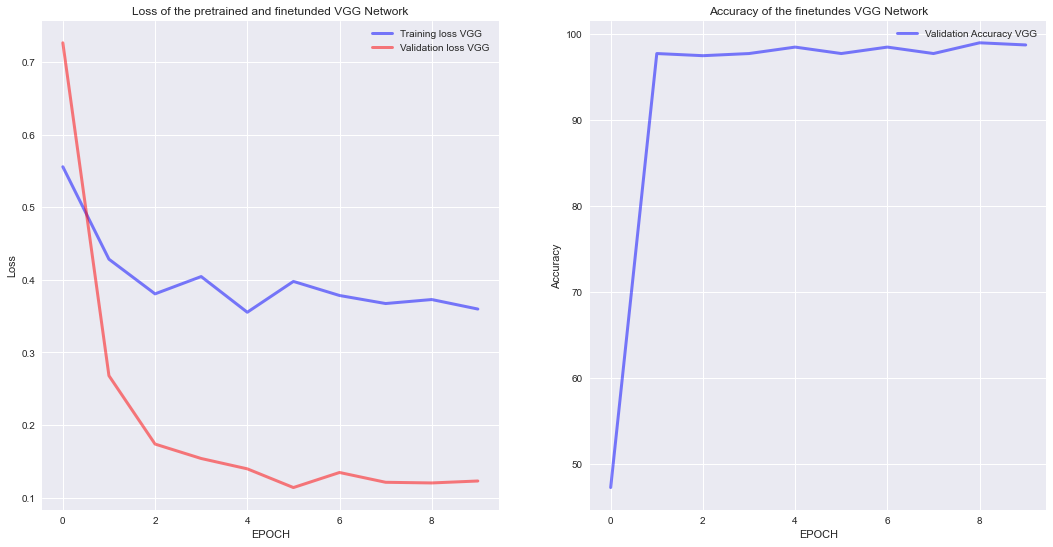

In [11]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)

ax[0].plot(tl_vgg, c="blue", label="Training loss VGG", linewidth=3, alpha=0.5)
ax[0].plot(vl_vgg, c="red", label="Validation loss VGG", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of the pretrained and finetunded VGG Network")

ax[1].plot(va_vgg, c="blue", label="Validation Accuracy VGG", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Accuracy of the finetundes VGG Network")

As we can see even after just a few epochs, we approach an accuracy of almost 100% with the fine tuned VGG net.

In [12]:
test_acc, test_loss = eval_model(model=model_vgg, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using VGG11: {}".format(test_acc))

Test Accuracy using VGG11: 99.43639291465378


In [13]:
#clear memory:
del model_vgg
del optimizer_vgg
del scheduler_vgg
gc.collect()
torch.cuda.empty_cache()

### 1.2 ResNet

In [14]:
model_res = models.resnet18(pretrained=True)
model_res.fc = nn. Linear(in_features=512, out_features=2, bias=True)
model_res.to(device)

optimizer_res = torch.optim.Adam(model_res.parameters(), lr=0.001)
criterion = CutMixCrossEntropyLoss(True)
scheduler_res = torch.optim.lr_scheduler.StepLR(optimizer_res, step_size=7, gamma=0.1)

In [15]:
tl_res, vl_res, va_res  = train_model(model=model_res, optimizer=optimizer_res, scheduler=scheduler_res, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS
    )

100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Epoch 1/10
    Train loss: 0.55884
    Accuracy: 52.0%




100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


Epoch 6/10
    Train loss: 0.31754
    Accuracy: 96.5%




100%|██████████| 50/50 [00:14<00:00,  3.34it/s]

Epoch 10/10
    Train loss: 0.30023
    Accuracy: 98.5%


Training completed


### 1.2.2 ResNet with fixed feature extractor

In [16]:
model_res_fix = models.resnet18(pretrained=True)
for param in model_res_fix.parameters():
    param.requires_grad = False
model_res_fix.fc = nn. Linear(in_features=512, out_features=2, bias=True)
model_res_fix.to(device)

criterion = CutMixCrossEntropyLoss(True)
optimizer_res_fix = torch.optim.Adam(model_res_fix.parameters(), lr=0.001)
scheduler_res_fix = torch.optim.lr_scheduler.StepLR(optimizer_res, step_size=7, gamma=0.1)

In [17]:
tl_res_fix, vl_res_fix, va_res_fix  = train_model(model=model_res_fix, optimizer=optimizer_res_fix, scheduler=scheduler_res_fix, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS
    )

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]
f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/10
    Train loss: 0.54587
    Accuracy: 42.0%




100%|██████████| 50/50 [00:14<00:00,  3.44it/s]


Epoch 6/10
    Train loss: 0.39523
    Accuracy: 93.75%




100%|██████████| 50/50 [00:14<00:00,  3.35it/s]

Epoch 10/10
    Train loss: 0.3825
    Accuracy: 98.0%


Training completed


Text(0.5, 1.0, 'Accuracy of the two ResNet Models')

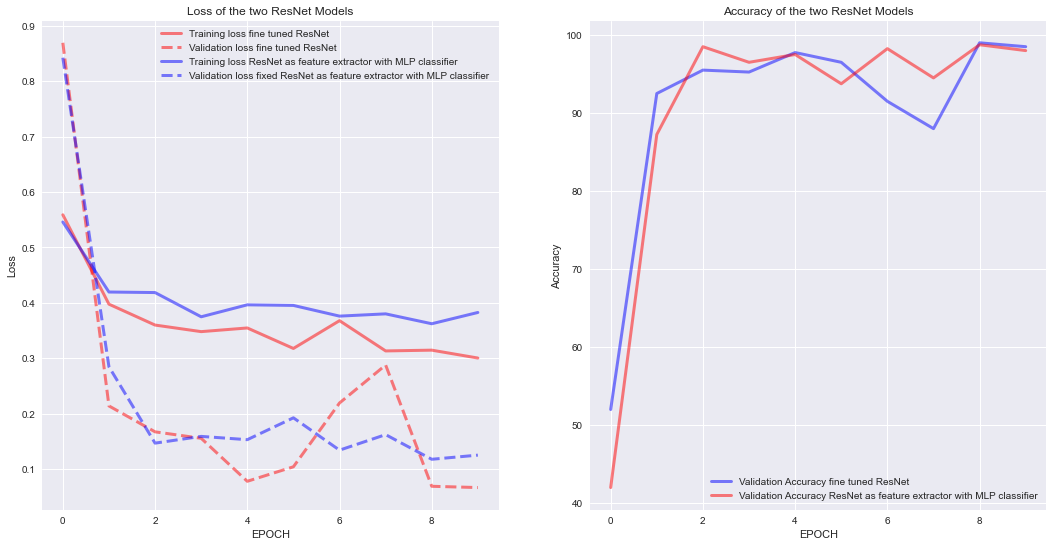

In [18]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)

ax[0].plot(tl_res, c="red", label="Training loss fine tuned ResNet", linewidth=3, alpha=0.5)
ax[0].plot(vl_res, c="red", linestyle='--', label="Validation loss fine tuned ResNet", linewidth=3, alpha=0.5)
ax[0].plot(tl_res_fix, c="blue", label="Training loss ResNet as feature extractor with MLP classifier", linewidth=3, alpha=0.5)
ax[0].plot(vl_res_fix, c="blue", linestyle='--', label="Validation loss fixed ResNet as feature extractor with MLP classifier", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of the two ResNet Models")

ax[1].plot(va_res, c="blue", label="Validation Accuracy fine tuned ResNet", linewidth=3, alpha=0.5)
ax[1].plot(va_res_fix, c="red", label="Validation Accuracy ResNet as feature extractor with MLP classifier", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Accuracy of the two ResNet Models")

In [19]:
test_acc_res, test_loss_res = eval_model(model=model_res, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using ResNet: {}".format(test_acc_res))
test_acc_fixres, test_loss_fixres = eval_model(model=model_res_fix, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using ResNet with fixed extractor: {}".format(test_acc_fixres))

Test Accuracy using ResNet: 99.27536231884058
Test Accuracy using ResNet with fixed extractor: 99.35587761674718


As we can see, the accuracy of the two Resnet Models is roughly the same. But the training and accuracy of the fine tuned resnet is far more unstable. This could be because the model is constantly on a cliff of the gradient where a small change of the weights causes a huge change in accuracy. 

In [20]:
#clear memory:
del model_res_fix
del model_res
del optimizer_res_fix
del optimizer_res
del scheduler_res_fix
del scheduler_res
gc.collect()
torch.cuda.empty_cache()

### 1.3 MobileNet

In [21]:
model_mobile = models.mobilenet_v2(pretrained=True)
model_mobile.classifier[1] = nn.Linear(1280, 2)
model_mobile.to(device)

optimizer_mobile = torch.optim.Adam(model_mobile.parameters(), lr=0.001)
criterion = CutMixCrossEntropyLoss(True)
scheduler_mobile = torch.optim.lr_scheduler.StepLR(optimizer_mobile, step_size=7, gamma=0.1)

In [22]:
tl_mobile, vl_mobile, va_mobile = train_model(model=model_mobile, optimizer=optimizer_mobile, scheduler=scheduler_mobile, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS
    )

100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Epoch 1/10
    Train loss: 0.4529
    Accuracy: 48.0%




100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 6/10
    Train loss: 0.32817
    Accuracy: 99.25%




100%|██████████| 50/50 [00:15<00:00,  3.25it/s]

Epoch 10/10
    Train loss: 0.29985
    Accuracy: 99.25%


Training completed


In [23]:
test_acc_mobile, test_loss_mobile = eval_model(model=model_mobile, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using MobileNet: {}".format(test_acc_mobile))

Test Accuracy using MobileNet: 99.7584541062802


Text(0.5, 1.0, 'Accuracy')

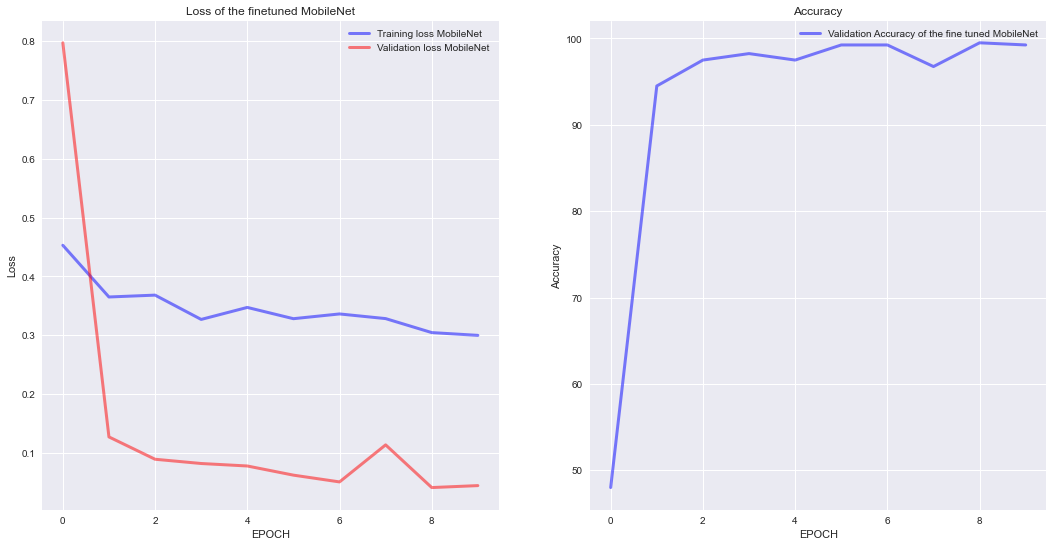

In [24]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)

ax[0].plot(tl_mobile, c="blue", label="Training loss MobileNet", linewidth=3, alpha=0.5)
ax[0].plot(vl_mobile, c="red", label="Validation loss MobileNet", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of the finetuned MobileNet")

ax[1].plot(va_mobile, c="blue", label="Validation Accuracy of the fine tuned MobileNet", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Accuracy")

In [25]:
test_acc_mobile, test_loss_mobile = eval_model(model=model_mobile, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using MobileNet: {}".format(test_acc_mobile))

Test Accuracy using MobileNet: 99.7584541062802


In [26]:
del model_mobile
del optimizer_mobile
del scheduler_mobile
gc.collect()
torch.cuda.empty_cache()

As we can see, mobile net works roughly the same as the Resnet and the VGG model

### 1.4 DenseNet

In [27]:
from sklearn import svm

In [28]:
model = models.densenet121(pretrained=True)


In [29]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="training", use_cache=True, subset=True)
test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="testing", use_cache=True, subset=True)


#we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 400, 400])  

train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=False)

In [31]:
#this identity code are used from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
model.classifier = Identity()

for param in model.parameters():
    param.requires_grad=False
labels = torch.tensor([])
outputs = torch.tensor([])
model
clf = svm.SVC()
for i, (images, label) in enumerate(tqdm(train_loader)):
    # images, labels = images.to(device), labels.to(device)


    output = model(images)
    if i==1:
        print(output.size())
    outputs = torch.cat((outputs, output))
    labels = torch.cat((labels, label))
    #print(outputs.size())
# outputs = outputs.cpu()
clf.fit(outputs.detach().numpy(), labels.numpy())

  4%|▍         | 2/50 [00:05<02:05,  2.62s/it]

torch.Size([32, 1024])


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


SVC()

In [32]:
model.eval()

correct = 0
total = 0
accuracy = []
for images, labels in tqdm(test_loader):
        
    # Forward pass only to get logits/output
    outputs = model(images)
    preds = clf.predict(outputs.detach().numpy())
              
    
    correct += len(np.where(preds==labels.numpy())[0])
    total += len(labels)
                 
    # Total correct predictions and loss
    accuracy.append(correct / total * 100)

print("Accuracy of the DenseNet feature extracotr with an SVM as classifier: ",np.mean(accuracy))



100%|██████████| 39/39 [01:32<00:00,  2.36s/it]

Accuracy of the DenseNet feature extracotr with an SVM as classifier:  99.62457410047666


In [ ]:
del model
del outputs
del labels
gc.collect()
torch.cuda.empty_cache()

In [33]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)
model.to(device)

criterion = CutMixCrossEntropyLoss(True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="training", use_cache=True, subset=True)
test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=data_transforms, mode="testing", use_cache=True, subset=True)


#we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 400, 400])  

train_dataset = CutMix(train_dataset, num_class=2, beta=1.0, prob=0.5, num_mix=2)


train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=False)

In [35]:
loss_dense, vl_dense, va_dense = train_model(model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS
    )

100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch 1/10
    Train loss: 0.49846
    Accuracy: 75.0%




100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Epoch 6/10
    Train loss: 0.35724
    Accuracy: 98.75%




100%|██████████| 50/50 [00:16<00:00,  3.09it/s]

Epoch 10/10
    Train loss: 0.34909
    Accuracy: 99.5%


Training completed


In [36]:
test_acc_dense, test_loss_dense = eval_model(model=model, eval_loader=test_loader, criterion=criterion, device=device)
print("Test Accuracy using DenseNet: {}".format(test_acc_dense))

Test Accuracy using MobileNet: 98.79227053140096


In [ ]:
del model
del optimizer
del scheduler
del train_loader
del valid_loader
del test_loader
gc.collect()
torch.cuda.empty_cache()

As we can see the performance with an SVM as a classifier is quite impressive with 99.81%, which is almost as good as our best classifier down below and better than the classifiers we trained above. Also this only needs to train for one epoch, which is quite an advantage over the MLP classifier.
The good performance of the SVM classifier is also not that surprising because an SVM can be seen as a 2 Layer fully connected network.

We can not really compare it to a fine tuned densenet because the model is to big to be trained on 10GB of GPU memory. So we only compare it with the MLP classifier.
The performance of the SVM as a classifier is better than the MLP and the training time is also shorter.
We would suggest, that the SVM is the clear winner here!

## Ex. 2 training with full dataset

To find the best combination of augmentations and parameters we run an optuna trial.

Augmentations:

In [7]:
possible_augmentations = [{
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
},
{
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
},
{
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}]

In [8]:
def objective(trial):
    n_epochs = 10
    model_name = trial.suggest_categorical("architecture", ["resnet50","resnet18", "vgg11"])
    model = getattr(torchvision.models, model_name)(pretrained=True)

    if model_name == "resnet18":
        model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
    elif model_name == "vgg11":
        model.classifier[-1] = nn.Linear(4096, 2)
    else:
        model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
    model = model.to(device)
    lr = 0.001
    mixup = trial.suggest_categorical("cutmix", [True, False])
    bsz = 32
    gamma = trial.suggest_categorical("gamma", [0.1,0.2,0.4,1.0])
    augmentation = trial.suggest_categorical("augmentation", possible_augmentations)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)


    TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=augmentation, mode="training", use_cache=True, subset=False)
    test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=augmentation, mode="testing", use_cache=True, subset=False)


    #we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
    train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 1280, 1280])  
    if mixup:
        train_dataset = CutMix(train_dataset, num_class=2, beta=1.0, prob=0.5, num_mix=2)


    train_loader_cut = DataLoader(train_dataset, batch_size=bsz, shuffle=True)
    valid_loader_cut = DataLoader(valid_dataset, batch_size=bsz, shuffle=True)
    test_loader_cut = DataLoader(test_dataset, batch_size=bsz, shuffle=False)


    if mixup:
        criterion = CutMixCrossEntropyLoss(True)
    else: 
        criterion = torch.nn.CrossEntropyLoss()
        
    print("Model: {}, Learning Rate: {}, Mixup: {}, Batchsize: {}, Gamma: {}".format(model_name, lr, str(mixup), bsz, gamma))

    for epoch in range(n_epochs):
        epoch_loss = train_epoch(model, train_loader_cut, optimizer, criterion, device)
        validation_acc, validation_loss = eval_model(model, valid_loader_cut, criterion, device)

        
        trial.report(validation_acc, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        scheduler.step()
    
    test_acc, test_loss = eval_model(model, test_loader_cut, criterion, device)
    print("Test accuracy: ", test_acc)

    #we sometimes had problems with memory leaks, so delete the references after each trial
    del model
    del optimizer
    del scheduler
    del train_loader_cut
    del valid_loader_cut
    del test_loader_cut
    gc.collect()
    torch.cuda.empty_cache()
    return test_acc 

In [9]:
import warnings
warnings.filterwarnings('ignore')
#supress the optuna warning which states, that a tuple is not useable for persistent storage, which we do not need
#use code from https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-05-29 18:32:53,422] A new study created in memory with name: no-name-5ef2a82c-a7e1-48e2-ba9d-adaad91cd7a2


Model: vgg11, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:51<00:00,  3.09it/s]
[I 2022-05-29 18:42:29,869] Trial 0 finished with value: 97.34299516908213 and parameters: {'architecture': 'vgg11', 'cutmix': True, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 97.34299516908213.


Test accuracy:  97.34299516908213
Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:14<00:00, 11.17it/s]
[I 2022-05-29 18:45:14,309] Trial 1 finished with value: 99.59742351046698 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 1 with value: 99.59742351046698.


Test accuracy:  99.59742351046698
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:09<00:00, 17.28it/s]
[I 2022-05-29 18:47:07,145] Trial 2 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet18', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 2 with value: 99.7584541062802.


Test accuracy:  99.7584541062802
Model: resnet50, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:21<00:00,  7.49it/s]
[I 2022-05-29 18:51:13,061] Trial 3 finished with value: 99.59742351046698 and parameters: {'architecture': 'resnet50', 'cutmix': True, 'gamma': 0.2, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 2 with value: 99.7584541062802.


Test accuracy:  99.59742351046698
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:33<00:00,  4.74it/s]
[I 2022-05-29 18:57:52,469] Trial 4 finished with value: 99.03381642512076 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 2 with value: 99.7584541062802.


Test accuracy:  99.03381642512076
Model: vgg11, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:49<00:00,  3.25it/s]
[I 2022-05-29 18:58:49,634] Trial 5 pruned. 


Model: vgg11, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:17<00:00,  8.93it/s]
[I 2022-05-29 18:59:11,186] Trial 6 pruned. 


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:20<00:00,  7.96it/s]
[I 2022-05-29 18:59:34,363] Trial 7 pruned. 


Model: vgg11, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:18<00:00,  8.85it/s]
[I 2022-05-29 18:59:55,924] Trial 8 pruned. 


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:32<00:00,  4.89it/s]
[I 2022-05-29 19:03:14,453] Trial 9 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:09<00:00, 17.39it/s]
[I 2022-05-29 19:03:47,935] Trial 10 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:14<00:00, 11.18it/s]
[I 2022-05-29 19:06:32,304] Trial 11 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 2 with value: 99.7584541062802.


Test accuracy:  99.7584541062802
Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:14<00:00, 11.26it/s]
[I 2022-05-29 19:09:15,022] Trial 12 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 2 with value: 99.7584541062802.


Test accuracy:  99.7584541062802
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:09<00:00, 17.33it/s]
[I 2022-05-29 19:09:26,291] Trial 13 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:09<00:00, 16.96it/s]
[I 2022-05-29 19:10:00,043] Trial 14 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:14<00:00, 10.86it/s]
[I 2022-05-29 19:10:50,368] Trial 15 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:13<00:00, 12.18it/s]
[I 2022-05-29 19:13:21,243] Trial 16 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 16 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:08<00:00, 18.04it/s]
[I 2022-05-29 19:14:56,669] Trial 17 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:08<00:00, 18.83it/s]
[I 2022-05-29 19:16:29,577] Trial 18 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:12<00:00, 12.67it/s]
[I 2022-05-29 19:18:39,627] Trial 19 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:08<00:00, 19.00it/s]
[I 2022-05-29 19:18:49,911] Trial 20 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:14<00:00, 11.18it/s]
[I 2022-05-29 19:20:27,154] Trial 21 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:14<00:00, 11.32it/s]
[I 2022-05-29 19:22:52,327] Trial 22 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:13<00:00, 12.10it/s]
[I 2022-05-29 19:25:23,105] Trial 23 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 16 with value: 99.8389694041868.


Test accuracy:  99.7584541062802
Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:15<00:00, 10.25it/s]
[I 2022-05-29 19:28:11,775] Trial 24 finished with value: 99.59742351046698 and parameters: {'architecture': 'resnet18', 'cutmix': True, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 16 with value: 99.8389694041868.


Test accuracy:  99.59742351046698
Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  15
  Number of complete trials:  10
Best trial:
  Value:  99.8389694041868
  Params: 
    architecture: resnet18
    cutmix: True
    gamma: 0.4
    augmentation: {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


The results really depend on the run, but we got an accuracy of 99.91 percent with a resnet 18, cutmix, gamma of 0.2 and Random Horizontal Flip and Random Rotation. with the full testset, 99.91% accuracy corresponds to only 1 image being misclassified
So lets train it

In [10]:
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn. Linear(in_features=512, out_features=2, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = CutMixCrossEntropyLoss(True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:

TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=transform, mode="training", use_cache=True, subset=False)
test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=transform, mode="testing", use_cache=True, subset=False)


#we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 1280, 1280])  
train_dataset = CutMix(train_dataset, num_class=2, beta=1.0, prob=0.5, num_mix=2)


train_loader_cut = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader_cut = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader_cut = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loss = []
validation_loss_list = []
validation_acc_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(10):

    epoch_loss = train_epoch(model, train_loader_cut, optimizer, criterion, device)
    validation_acc, validation_loss = eval_model(model, valid_loader_cut, criterion, device)

    train_loss.append(epoch_loss)
    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    
    scheduler.step()

    test_acc, test_loss = eval_model(model, test_loader_cut, criterion, device)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    print("Test accuracy: ", test_acc)


100%|██████████| 160/160 [00:16<00:00,  9.71it/s]


Test accuracy:  99.19484702093398


100%|██████████| 160/160 [00:14<00:00, 10.79it/s]


Test accuracy:  96.69887278582931


100%|██████████| 160/160 [00:15<00:00, 10.66it/s]


Test accuracy:  98.55072463768117


100%|██████████| 160/160 [00:14<00:00, 10.70it/s]


Test accuracy:  99.35587761674718


100%|██████████| 160/160 [00:20<00:00,  7.73it/s]


Test accuracy:  98.55072463768117


100%|██████████| 160/160 [00:18<00:00,  8.72it/s]


Test accuracy:  99.35587761674718


100%|██████████| 160/160 [00:17<00:00,  9.24it/s]


Test accuracy:  99.7584541062802


100%|██████████| 160/160 [00:17<00:00,  9.34it/s]


Test accuracy:  99.7584541062802


100%|██████████| 160/160 [00:17<00:00,  9.36it/s]


Test accuracy:  99.8389694041868


100%|██████████| 160/160 [00:17<00:00,  9.22it/s]


Test accuracy:  99.7584541062802


Text(0.5, 1.0, 'Accuracyof the best performing model')

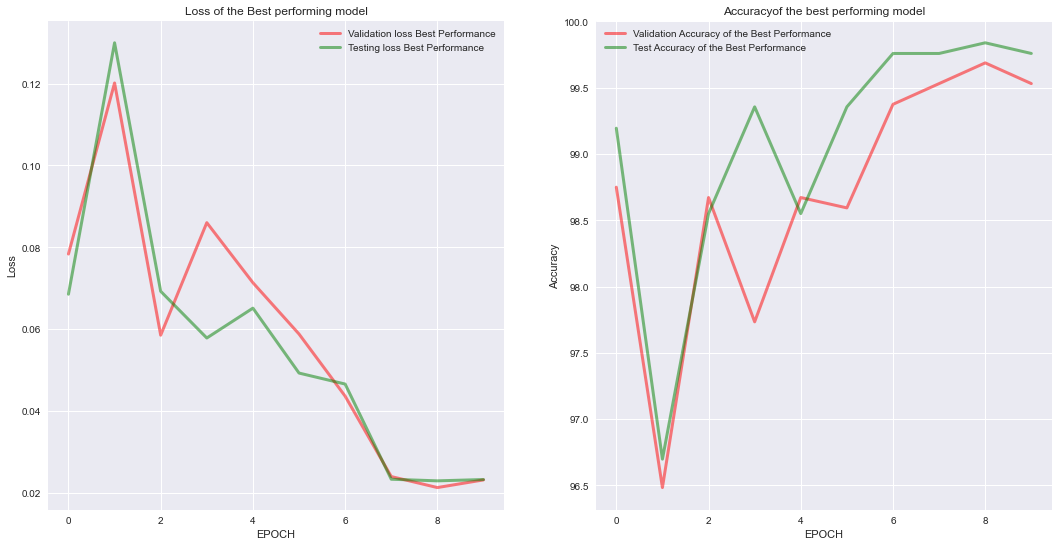

In [18]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)

#ax[0].plot(train_loss, c="blue", label="Training loss Best Performance", linewidth=3, alpha=0.5)
ax[0].plot(validation_loss_list, c="red", label="Validation loss Best Performance", linewidth=3, alpha=0.5)
ax[0].plot(test_loss_list, c="green", label="Testing loss Best Performance", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of the Best performing model")

ax[1].plot(validation_acc_list, c="red", label="Validation Accuracy of the Best Performance", linewidth=3, alpha=0.5)
ax[1].plot(test_acc_list, c="green", label="Test Accuracy of the Best Performance", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Accuracyof the best performing model")

AS we can see, the loss is bouncing up and down like before. It also is quite a bit of initialization prone if we really achieve the 91.91% accuracy

Finally, lets try the performance for the fixed feature extractor for all resnet variants:

In [ ]:
def objective_fixed(trial):
    n_epochs = 10
    model_name = trial.suggest_categorical("architecture", ["resnet50","resnet18", "resnet101", "resnet152"])
    model = getattr(torchvision.models, model_name)(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False
    if model_name == "resnet18":
        model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
    else:
        model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
    model = model.to(device)
    lr = 0.001
    mixup = trial.suggest_categorical("cutmix", [True, False])
    bsz = 32
    gamma = trial.suggest_categorical("gamma", [0.1,0.2,0.4,1.0])
    augmentation = trial.suggest_categorical("augmentation", possible_augmentations)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)


    TG_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=augmentation, mode="training", use_cache=True, subset=False)
    test_dataset = GlassesAndTables(root_dir="./data/", custom_transforms=augmentation, mode="testing", use_cache=True, subset=False)


    #we use 20% as our validation set which is 400 or 1280 depends on if we use subset or not
    train_dataset, valid_dataset =  torch.utils.data.random_split(TG_dataset, [len(TG_dataset) - 1280, 1280])  
    if mixup:
        train_dataset = CutMix(train_dataset, num_class=2, beta=1.0, prob=0.5, num_mix=2)


    train_loader_cut = DataLoader(train_dataset, batch_size=bsz, shuffle=True)
    valid_loader_cut = DataLoader(valid_dataset, batch_size=bsz, shuffle=True)
    test_loader_cut = DataLoader(test_dataset, batch_size=bsz, shuffle=False)


    if mixup:
        criterion = CutMixCrossEntropyLoss(True)
    else: 
        criterion = torch.nn.CrossEntropyLoss()
        
    print("Model: {}, Learning Rate: {}, Mixup: {}, Batchsize: {}, Gamma: {}".format(model_name, lr, str(mixup), bsz, gamma))

    for epoch in range(n_epochs):
        epoch_loss = train_epoch(model, train_loader_cut, optimizer, criterion, device)
        validation_acc, validation_loss = eval_model(model, valid_loader_cut, criterion, device)

        
        trial.report(validation_acc, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        scheduler.step()
    
    test_acc, test_loss = eval_model(model, test_loader_cut, criterion, device)
    print("Test accuracy: ", test_acc)
    return test_acc 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#supress the optuna warning which states, that a tuple is not useable for persistent storage, which we do not need
#use code from https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
study = optuna.create_study(direction="maximize")
study.optimize(objective_fixed,n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-05-29 00:17:05,397] A new study created in memory with name: no-name-b09d828b-9fbb-4b37-9da7-a36477384a41


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:29<00:00,  5.39it/s]
[I 2022-05-29 00:23:06,618] Trial 0 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.7584541062802
Model: resnet101, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:33<00:00,  4.78it/s]
[I 2022-05-29 00:30:06,261] Trial 1 finished with value: 99.59742351046698 and parameters: {'architecture': 'resnet101', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.59742351046698
Model: resnet152, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:23<00:00,  6.67it/s]
[I 2022-05-29 00:34:59,122] Trial 2 finished with value: 99.03381642512076 and parameters: {'architecture': 'resnet152', 'cutmix': True, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.03381642512076
Model: resnet101, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:29<00:00,  5.36it/s]
[I 2022-05-29 00:41:23,406] Trial 3 finished with value: 99.6779388083736 and parameters: {'architecture': 'resnet101', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.6779388083736
Model: resnet152, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:16<00:00,  9.73it/s]
[I 2022-05-29 00:44:52,613] Trial 4 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet152', 'cutmix': False, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.7584541062802
Model: resnet101, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:50<00:00,  3.17it/s]
[I 2022-05-29 00:45:51,030] Trial 5 pruned. 


Model: resnet152, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:21<00:00,  7.61it/s]
[I 2022-05-29 00:50:08,547] Trial 6 finished with value: 99.19484702093398 and parameters: {'architecture': 'resnet152', 'cutmix': True, 'gamma': 0.2, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 0 with value: 99.7584541062802.


Test accuracy:  99.19484702093398
Model: resnet18, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:43<00:00,  3.68it/s]
[I 2022-05-29 00:50:57,758] Trial 7 pruned. 


Model: resnet152, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:16<00:00,  9.68it/s]
[I 2022-05-29 00:54:25,301] Trial 8 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet152', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet152, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.1


100%|██████████| 160/160 [00:16<00:00,  9.67it/s]
[I 2022-05-29 00:57:55,178] Trial 9 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet152', 'cutmix': False, 'gamma': 0.1, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.7584541062802
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:06<00:00, 25.08it/s]
[I 2022-05-29 00:58:03,290] Trial 10 pruned. 


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:09<00:00, 16.77it/s]
[I 2022-05-29 01:00:04,048] Trial 11 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:09<00:00, 16.81it/s]
[I 2022-05-29 01:02:04,851] Trial 12 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:09<00:00, 17.08it/s]
[I 2022-05-29 01:04:05,421] Trial 13 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:09<00:00, 17.03it/s]
[I 2022-05-29 01:06:04,368] Trial 14 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet152, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:18<00:00,  8.62it/s]
[I 2022-05-29 01:09:39,790] Trial 15 finished with value: 99.51690821256038 and parameters: {'architecture': 'resnet152', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.51690821256038
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:11<00:00, 13.60it/s]
[I 2022-05-29 01:10:09,199] Trial 16 pruned. 


Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:07<00:00, 22.78it/s]
[I 2022-05-29 01:11:37,545] Trial 17 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet18', 'cutmix': False, 'gamma': 0.2, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet152, Learning Rate: 0.001, Mixup: True, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]
[I 2022-05-29 01:12:07,762] Trial 18 pruned. 


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:11<00:00, 14.23it/s]
[I 2022-05-29 01:14:30,171] Trial 19 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:07<00:00, 22.07it/s]
[I 2022-05-29 01:16:01,483] Trial 20 finished with value: 99.7584541062802 and parameters: {'architecture': 'resnet18', 'cutmix': False, 'gamma': 0.2, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.7584541062802
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.2


100%|██████████| 160/160 [00:07<00:00, 22.15it/s]
[I 2022-05-29 01:16:10,644] Trial 21 pruned. 


Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 1.0


100%|██████████| 160/160 [00:11<00:00, 14.22it/s]
[I 2022-05-29 01:18:32,327] Trial 22 finished with value: 99.43639291465378 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 1.0, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.43639291465378
Model: resnet50, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:11<00:00, 14.24it/s]
[I 2022-05-29 01:20:53,973] Trial 23 finished with value: 99.8389694041868 and parameters: {'architecture': 'resnet50', 'cutmix': False, 'gamma': 0.4, 'augmentation': {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}}. Best is trial 8 with value: 99.8389694041868.


Test accuracy:  99.8389694041868
Model: resnet18, Learning Rate: 0.001, Mixup: False, Batchsize: 32, Gamma: 0.4


100%|██████████| 160/160 [00:07<00:00, 22.05it/s]
[I 2022-05-29 01:21:12,008] Trial 24 pruned. 


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  7
  Number of complete trials:  18
Best trial:
  Value:  99.8389694041868
  Params: 
    architecture: resnet152
    cutmix: False
    gamma: 1.0
    augmentation: {'train': Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}
